In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys, os

# Path to the folder where utils.py is located
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts'

# Add to Python's import search path
sys.path.append(GOOGLE_DRIVE_PATH)

# Check that utils.py is visible
print("Files in path:", os.listdir(GOOGLE_DRIVE_PATH))

# Now import the helper functions


Mounted at /content/drive
Files in path: ['finbert_embed_demo.py', '__pycache__', 'Trans.py', 'runner.ipynb']


In [4]:
%cd $GOOGLE_DRIVE_PATH

/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/scripts


In [131]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from Trans import train_transformer, predict, train_classifier
import matplotlib.pyplot as plt

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [134]:
news_path = "/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/data/cryptonews.csv"
df = pd.read_csv(news_path)
## Test with sample data
# df = df[:1000]
df.head()

,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...


In [135]:
## Text Data Preprocessing
if 'date' not in df.columns:
    raise ValueError("no 'date' column")

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['content'] = (
    "Subject: " +
    df['subject'] + ". " +
    df['title'].fillna('') + ". " +
    df['text'].fillna('')
)
df = df[df['content'].str.strip() != ""]
df = df.reset_index(drop=True)
print("Example content:\n", df['content'].iloc[0])

Example content:
 Subject: altcoin. Grayscale CEO Calls for Simultaneous Approval of Spot Products to Level the Field. Grayscale CEO Michael Sonnenshein believes the SEC needs to approve spot Bitcoin exchange-traded funds (ETFs) simultaneously.


/tmp/ipython-input-135-4135063911.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = (


In [9]:
## Finbert embedding
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert").to(device)
model.eval()

def get_cls_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
    return cls_emb

emb_list = []

print("Generating CLS embeddings with subject-aware input…")
for text in tqdm(df['content'], total=len(df)):
    emb = get_cls_embedding(text)
    emb_list.append(emb)

emb_matrix = np.vstack(emb_list)   # (N, 768)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Generating CLS embeddings with subject-aware input…


  0%|          | 0/31035 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

100%|██████████| 31035/31035 [04:34<00:00, 113.13it/s]


In [136]:
## Hourly Text Embeddings
emb_cols = [f"emb_{i}" for i in range(768)]
emb_df = pd.DataFrame(emb_matrix, columns=emb_cols)
df_emb = pd.concat([df[['date']].reset_index(drop=True), emb_df], axis=1)
df_emb['date_hour'] = df_emb['date'].dt.floor('H') - pd.Timedelta(hours=1)
hourly_emb = df_emb.groupby('date_hour')[emb_cols].mean().reset_index()
hourly_emb.head()

/tmp/ipython-input-136-3957886434.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_emb['date_hour'] = df_emb['date'].dt.floor('H') - pd.Timedelta(hours=1)


,date_hour,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,2021-10-12 19:00:00,0.912152,-0.289897,-0.106474,-0.113026,0.394453,-0.922069,-0.138459,-0.283882,1.058859,...,-0.885016,1.097258,0.250816,-0.247281,0.158346,0.911171,0.306549,-0.525593,-0.237293,-0.126576
1,2021-10-14 23:00:00,0.832355,-0.565270,-0.155376,0.177041,-0.404988,0.186594,0.197058,0.342728,-0.184108,...,-0.676372,0.006813,1.276712,-0.691504,0.527739,-0.028155,0.792983,0.054099,0.871576,-0.343787
2,2021-10-18 12:00:00,0.841546,0.201940,-0.550001,-0.270046,0.169722,-0.378043,-0.160431,-0.141538,0.687665,...,-0.766616,0.651080,0.087984,-0.106784,-0.241353,0.472269,0.126335,0.196425,-0.146727,0.568042
3,2021-10-19 12:00:00,0.555220,-0.005443,-0.500097,0.261368,-0.107944,-0.540353,-0.520262,-0.307783,0.481327,...,-0.189013,0.628675,-0.414788,-0.596011,-0.610709,1.007512,0.310567,-0.076615,-0.385678,0.154618
4,2021-10-27 14:00:00,-0.072922,-0.593994,0.173647,-0.565007,-0.645257,1.852983,1.157734,0.352569,-0.325214,...,-0.560448,-0.607751,0.521281,-0.430741,-0.109788,-0.321072,0.562547,0.500778,0.126169,0.359122


In [137]:
## Price Data
price_path = r"/content/drive/MyDrive/CS7643 Project/OMSCS_7643_F2025_Project/data/BTC_USD_hourly.parquet"
price_df = pd.read_parquet(price_path)
price_df['date_hour'] = pd.to_datetime(price_df['datetime'], errors='coerce').dt.tz_localize(None).dt.floor('H')
price_df = price_df.drop(columns=['datetime'])
price_df.head()

/tmp/ipython-input-137-1075665587.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_df['date_hour'] = pd.to_datetime(price_df['datetime'], errors='coerce').dt.tz_localize(None).dt.floor('H')


,open,high,low,close,date_hour
0,47983.92188,48281.96875,47928.109380,47967.66016,2021-05-15 22:00:00
1,47964.33984,47964.33984,46635.070312,46738.80859,2021-05-15 23:00:00
2,46775.80078,47673.53906,46520.558590,47264.71094,2021-05-16 00:00:00
3,47276.55078,48139.62891,47276.550780,48061.92969,2021-05-16 01:00:00
4,48064.48047,48289.98828,47964.160160,48152.69922,2021-05-16 02:00:00


In [138]:
df = price_df.merge(hourly_emb, on='date_hour', how='inner')
df = df.sort_values('date_hour').reset_index(drop=True)
print("Merged shape:", df.shape)

Merged shape: (13263, 773)


###**Predict Price**

In [ ]:
df['target_close'] = df['close'].shift(-1)
df = df.dropna().reset_index(drop=True)
df.head()

In [80]:
price_cols = ['open', 'high', 'low', 'close']
emb_cols = [c for c in df.columns if c.startswith("emb_")]

feature_dim = len(price_cols) + len(emb_cols)
print("feature_dim =", feature_dim)

feature_dim = 772


In [81]:
total_len = len(df)
train_end = int(total_len * 0.7)

train_df = df.iloc[:train_end]
test_df  = df.iloc[train_end:]

sub_end = int(len(train_df) * 0.9)
subtrain_df = train_df.iloc[:sub_end]
val_df      = train_df.iloc[sub_end:]

In [82]:
scaler_price = MinMaxScaler()
scaler_price.fit(subtrain_df[price_cols])

sub_price  = scaler_price.transform(subtrain_df[price_cols])
val_price  = scaler_price.transform(val_df[price_cols])
test_price = scaler_price.transform(test_df[price_cols])

# embedding
sub_emb  = subtrain_df[emb_cols].values * 0.01
val_emb  = val_df[emb_cols].values * 0.01
test_emb = test_df[emb_cols].values * 0.01

# combine
X_sub_df  = np.concatenate([sub_price,  sub_emb],  axis=1)
X_val_df  = np.concatenate([val_price,  val_emb],  axis=1)
X_test_df = np.concatenate([test_price, test_emb], axis=1)

# y scaler
scaler_y = MinMaxScaler()
scaler_y.fit(subtrain_df[['target_close']])

y_sub  = scaler_y.transform(subtrain_df[['target_close']]).reshape(-1)
y_val  = scaler_y.transform(val_df[['target_close']]).reshape(-1)
y_test = scaler_y.transform(test_df[['target_close']]).reshape(-1)


In [83]:
def build_sequences(X_block, y_block, seq_len=12):
    X_list, y_list = [], []

    for i in range(seq_len, len(X_block)):
        X_list.append(X_block[i-seq_len:i])
        y_list.append(y_block[i])

    return np.array(X_list), np.array(y_list)


seq_len = 12

X_sub,  y_sub_seq  = build_sequences(X_sub_df,  y_sub,  seq_len)
X_val,  y_val_seq  = build_sequences(X_val_df,  y_val,  seq_len)
X_test, y_test_seq = build_sequences(X_test_df, y_test, seq_len)

print("Sub:", X_sub.shape, y_sub_seq.shape)
print("Val:", X_val.shape, y_val_seq.shape)
print("Test:", X_test.shape, y_test_seq.shape)


Sub: (8342, 12, 772) (8342,)
Val: (917, 12, 772) (917,)
Test: (3967, 12, 772) (3967,)


In [84]:
X_train_all = np.concatenate([X_sub, X_val], axis=0)
y_train_all = np.concatenate([y_sub_seq, y_val_seq], axis=0)


model, train_losses, val_losses = train_transformer(
    X_train_all,
    y_train_all,
    batch_size=32,
    lr=1e-4,
    epochs=30
)

Epoch 01 | Train Loss 0.012811 | Val Loss 0.000067
Epoch 02 | Train Loss 0.001347 | Val Loss 0.000661
Epoch 03 | Train Loss 0.000913 | Val Loss 0.000147
Epoch 04 | Train Loss 0.000704 | Val Loss 0.000072
Epoch 05 | Train Loss 0.000578 | Val Loss 0.000400
Epoch 06 | Train Loss 0.000489 | Val Loss 0.000635
Epoch 07 | Train Loss 0.000433 | Val Loss 0.000276
Epoch 08 | Train Loss 0.000389 | Val Loss 0.000044
Epoch 09 | Train Loss 0.000338 | Val Loss 0.000049
Epoch 10 | Train Loss 0.000322 | Val Loss 0.000068
Epoch 11 | Train Loss 0.000301 | Val Loss 0.000049
Epoch 12 | Train Loss 0.000300 | Val Loss 0.000074
Epoch 13 | Train Loss 0.000256 | Val Loss 0.000078
Epoch 14 | Train Loss 0.000242 | Val Loss 0.000038
Epoch 15 | Train Loss 0.000218 | Val Loss 0.000091
Epoch 16 | Train Loss 0.000228 | Val Loss 0.000037
Epoch 17 | Train Loss 0.000202 | Val Loss 0.000121
Epoch 18 | Train Loss 0.000204 | Val Loss 0.000038
Epoch 19 | Train Loss 0.000195 | Val Loss 0.000064
Epoch 20 | Train Loss 0.000189 

In [85]:
# ---- test prediction ----
pred_norm = predict(model, X_test)           # (N_test,)
pred_price = scaler_y.inverse_transform(pred_norm.reshape(-1, 1)).reshape(-1)

# ---- ground truth ----
y_true_price = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(-1)


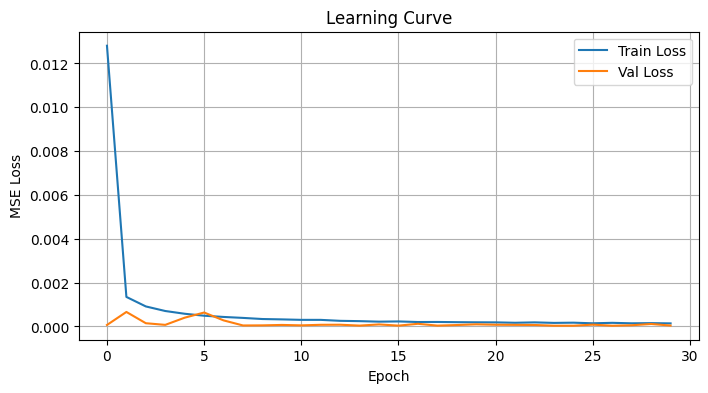

In [87]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

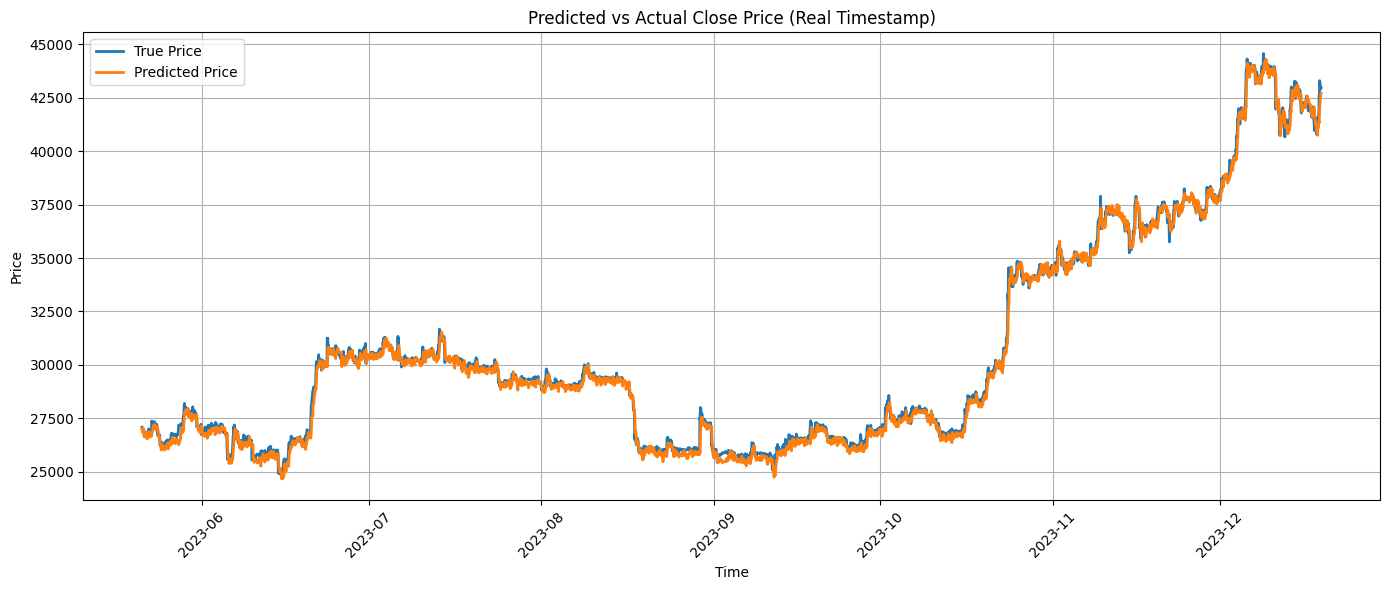

In [88]:
test_timestamps = test_df['date_hour'].values
test_seq_timestamps = test_timestamps[seq_len:]

plt.figure(figsize=(14,6))
plt.plot(test_seq_timestamps, y_true_price, label='True Price', linewidth=2)
plt.plot(test_seq_timestamps, pred_price, label='Predicted Price', linewidth=2)

plt.title("Predicted vs Actual Close Price (Real Timestamp)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [89]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse_norm = mean_squared_error(y_test_seq, pred_norm)
mse_real = mean_squared_error(y_true_price, pred_price)

rmse = np.sqrt(mse_real)
mae  = np.mean(np.abs(y_true_price - pred_price))
mape = np.mean(np.abs((y_true_price - pred_price) / y_true_price)) * 100
acc  = 1 - mape/100   # vs paper

print("Normalized MSE:", mse_norm)
print("Real Price MSE:", mse_real)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE(%):", mape)
print("Accuracy:", acc)


Normalized MSE: 2.7894262409415358e-05
Real Price MSE: 78144.19476609273
RMSE: 279.54283172010105
MAE: 206.6159836787245
MAPE(%): 0.6856298920710796
Accuracy: 0.9931437010792892


**Predict Retrurn**

In [109]:
df['target_ret'] = df['close'].pct_change().shift(-1)
df = df.dropna().reset_index(drop=True)

In [110]:
total_len = len(df)
train_end = int(total_len * 0.7)

train_df = df.iloc[:train_end]
test_df  = df.iloc[train_end:]

sub_end = int(len(train_df) * 0.9)
subtrain_df = train_df.iloc[:sub_end]
val_df      = train_df.iloc[sub_end:]
scaler_price = MinMaxScaler()
scaler_price.fit(subtrain_df[price_cols])

sub_price  = scaler_price.transform(subtrain_df[price_cols])
val_price  = scaler_price.transform(val_df[price_cols])
test_price = scaler_price.transform(test_df[price_cols])

sub_emb  = subtrain_df[emb_cols].values * 0.01
val_emb  = val_df[emb_cols].values * 0.01
test_emb = test_df[emb_cols].values * 0.01

X_sub_df  = np.concatenate([sub_price,  sub_emb],  axis=1)
X_val_df  = np.concatenate([val_price,  val_emb],  axis=1)
X_test_df = np.concatenate([test_price, test_emb], axis=1)

In [112]:
from sklearn.preprocessing import StandardScaler

scaler_ret = StandardScaler()
scaler_ret.fit(subtrain_df[['target_ret']])

y_sub  = scaler_ret.transform(subtrain_df[['target_ret']]).reshape(-1)
y_val  = scaler_ret.transform(val_df[['target_ret']]).reshape(-1)
y_test = scaler_ret.transform(test_df[['target_ret']]).reshape(-1)

In [113]:
X_sub,  y_sub_seq  = build_sequences(X_sub_df,  y_sub,  seq_len=12)
X_val,  y_val_seq  = build_sequences(X_val_df,  y_val,  seq_len=12)
X_test, y_test_seq = build_sequences(X_test_df, y_test, seq_len=12)

In [115]:
X_train_all = np.concatenate([X_sub, X_val], axis=0)
y_train_all = np.concatenate([y_sub_seq, y_val_seq], axis=0)

model, train_losses, val_losses = train_transformer(
    X_train_all,
    y_train_all,
    lr=1e-4,
    batch_size=32,
    epochs=30
)

pred_norm = predict(model, X_test)
pred_ret = scaler_ret.inverse_transform(pred_norm.reshape(-1,1)).reshape(-1)

Epoch 01 | Train Loss 1.025055 | Val Loss 0.558213
Epoch 02 | Train Loss 1.028093 | Val Loss 0.557993
Epoch 03 | Train Loss 1.023346 | Val Loss 0.559547
Epoch 04 | Train Loss 1.024934 | Val Loss 0.555047
Epoch 05 | Train Loss 1.022160 | Val Loss 0.554299
Epoch 06 | Train Loss 1.021192 | Val Loss 0.560137
Epoch 07 | Train Loss 1.024054 | Val Loss 0.554160
Epoch 08 | Train Loss 1.021012 | Val Loss 0.560035
Epoch 09 | Train Loss 1.022807 | Val Loss 0.558191
Epoch 10 | Train Loss 1.019739 | Val Loss 0.555922
Epoch 11 | Train Loss 1.022609 | Val Loss 0.555089
Epoch 12 | Train Loss 1.024522 | Val Loss 0.556096
Epoch 13 | Train Loss 1.074278 | Val Loss 0.554360
Epoch 14 | Train Loss 1.022280 | Val Loss 0.556318
Epoch 15 | Train Loss 1.028927 | Val Loss 0.556889
Epoch 16 | Train Loss 1.020723 | Val Loss 0.554141
Epoch 17 | Train Loss 1.021372 | Val Loss 0.555966
Epoch 18 | Train Loss 1.021515 | Val Loss 0.554216
Epoch 19 | Train Loss 1.021944 | Val Loss 0.555945
Epoch 20 | Train Loss 1.023450 

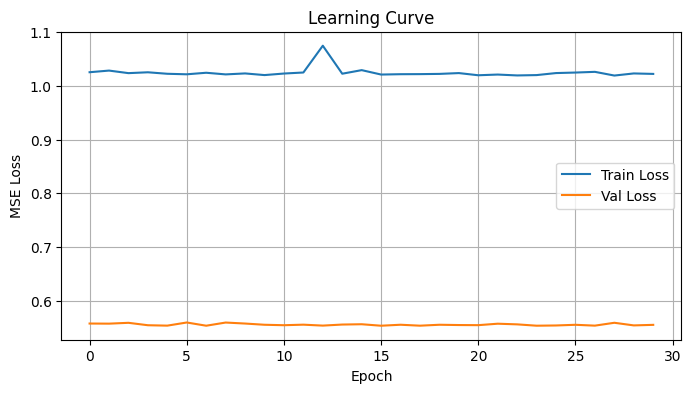

In [116]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

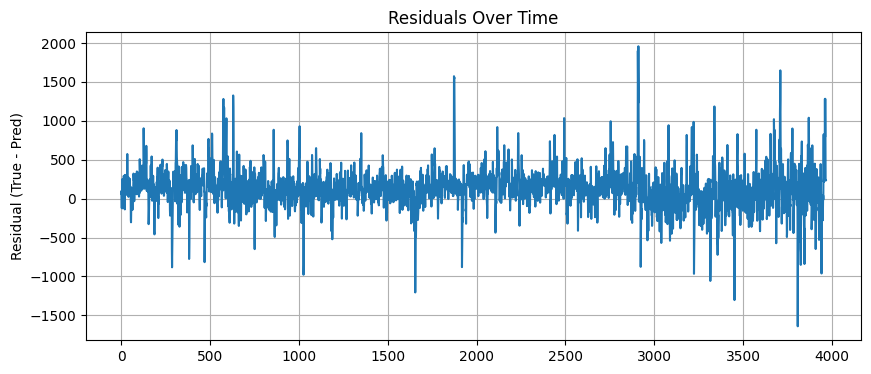

In [145]:
residuals = y_true_price - pred_price

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.ylabel("Residual (True - Pred)")
plt.grid(True)
plt.show()

In [117]:
from sklearn.metrics import mean_squared_error, r2_score

print("Return MSE:", mean_squared_error(y_test_seq, pred_norm))
print("Return R2:", r2_score(y_test_seq, pred_norm))

Return MSE: 0.2716944426545056
Return R2: -0.01020100809406399


**Classify Up_Down**

In [139]:
df['return'] = df['close'].pct_change()
df['label'] = (df['return'] > 0).astype(int)
df = df.dropna().reset_index(drop=True)

In [140]:
total_len = len(df)
train_end = int(total_len * 0.7)

train_df = df.iloc[:train_end]
test_df  = df.iloc[train_end:]

sub_end = int(len(train_df) * 0.9)
subtrain_df = train_df.iloc[:sub_end]
val_df      = train_df.iloc[sub_end:]

price_cols = ['open', 'high', 'low', 'close']
emb_cols   = [c for c in df.columns if c.startswith("emb_")]

# --- price scaler ---
scaler_price = MinMaxScaler()
scaler_price.fit(subtrain_df[price_cols])

sub_price  = scaler_price.transform(subtrain_df[price_cols])
val_price  = scaler_price.transform(val_df[price_cols])
test_price = scaler_price.transform(test_df[price_cols])

# --- embedding (scale ×0.01) ---
sub_emb  = subtrain_df[emb_cols].values * 0.01
val_emb  = val_df[emb_cols].values * 0.01
test_emb = test_df[emb_cols].values * 0.01

# --- combine ---
X_sub_df  = np.concatenate([sub_price,  sub_emb],  axis=1)
X_val_df  = np.concatenate([val_price,  val_emb],  axis=1)
X_test_df = np.concatenate([test_price, test_emb], axis=1)

# --- labels (classification) ---
y_sub  = subtrain_df['label'].values
y_val  = val_df['label'].values
y_test = test_df['label'].values

In [141]:
def build_sequences(X_block, y_block, seq_len=12):
    X_list, y_list = [], []

    for i in range(seq_len, len(X_block)):
        X_list.append(X_block[i-seq_len:i])
        y_list.append(y_block[i])

    return np.array(X_list), np.array(y_list)

seq_len = 12

X_sub,  y_sub_seq  = build_sequences(X_sub_df,  y_sub,  seq_len)
X_val,  y_val_seq  = build_sequences(X_val_df,  y_val,  seq_len)
X_test, y_test_seq = build_sequences(X_test_df, y_test, seq_len)

print("Shapes:")
print("Train:", X_sub.shape, y_sub_seq.shape)
print("Val:",   X_val.shape, y_val_seq.shape)
print("Test:",  X_test.shape, y_test_seq.shape)

Shapes:
Train: (8342, 12, 772) (8342,)
Val: (917, 12, 772) (917,)
Test: (3967, 12, 772) (3967,)


In [142]:
model = train_classifier(
    X_sub, y_sub_seq,
    X_val, y_val_seq,
    lr=1e-4,
    epochs=20,
    batch_size=32
)


Epoch 1/20 | Val Loss = 0.6983
Epoch 2/20 | Val Loss = 0.7057
Epoch 3/20 | Val Loss = 0.7045
Epoch 4/20 | Val Loss = 0.6938
Epoch 5/20 | Val Loss = 0.6930
Epoch 6/20 | Val Loss = 0.6975
Epoch 7/20 | Val Loss = 0.6930
Epoch 8/20 | Val Loss = 0.6945
Epoch 9/20 | Val Loss = 0.6962
Epoch 10/20 | Val Loss = 0.7038
Epoch 11/20 | Val Loss = 0.6945
Epoch 12/20 | Val Loss = 0.6934
Epoch 13/20 | Val Loss = 0.7006
Epoch 14/20 | Val Loss = 0.6994
Epoch 15/20 | Val Loss = 0.6982
Epoch 16/20 | Val Loss = 0.6949
Epoch 17/20 | Val Loss = 0.6955
Epoch 18/20 | Val Loss = 0.6938
Epoch 19/20 | Val Loss = 0.6941
Epoch 20/20 | Val Loss = 0.6953


In [143]:
from sklearn.metrics import accuracy_score, roc_auc_score

model.eval()
device = next(model.parameters()).device

with torch.no_grad():
    logits = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    prob = torch.sigmoid(logits).cpu().numpy()
    pred_label = (prob > 0.5).astype(int)

acc = accuracy_score(y_test_seq, pred_label)
auc = roc_auc_score(y_test_seq, prob)

print("Test Accuracy:", acc)
print("Test AUC:", auc)

Test Accuracy: 0.5046634736576758
Test AUC: 0.506414324396476
